# Benckmarking Dataset 3

In [8]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import time
import logging
from sklearn.linear_model import LinearRegression
from scipy.spatial import distance_matrix

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import shutil
from sklearn.metrics.pairwise import cosine_similarity

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../src')
from utils import *

# Preprocessing MERFISH Mouse brain section 2 data
We use a single-cell resolution MERFISH Mouse brain dataset to generate a simulated dataset. The raw MEREFISH Mouse brain dataset is available in [here](https://cellxgene.cziscience.com/collections/31937775-0602-4e52-a799-b6acdd2bac2e). Conveniently, we provided the pre-pocessed benchmarking Dataset 3 (demo_data/MERFISH_MBA_sp_D8S1.h5ad and demo_data/MERFISH_MBA_scref.h5ad) as well as other relevent materials involved in the following example in [here](https://drive.google.com/drive/folders/1PXv_brtr-tXshBVEd_HSPIagjX9oF7Kg?usp=sharing)

In [2]:
sp_adata = sc.read('../demo_data/MERFISH_MBA_sp_D8S1.h5ad')
sc_adata = sc.read('../demo_data/MERFISH_MBA_scref.h5ad')

In [3]:
sp_adata.obs['cell_type_annot'].value_counts()

ExN      623
Astro    324
InN      202
Endo     158
Olig     156
Micro     90
OPC       77
Peri      66
Vlmc      62
MSN       10
Name: cell_type_annot, dtype: int64

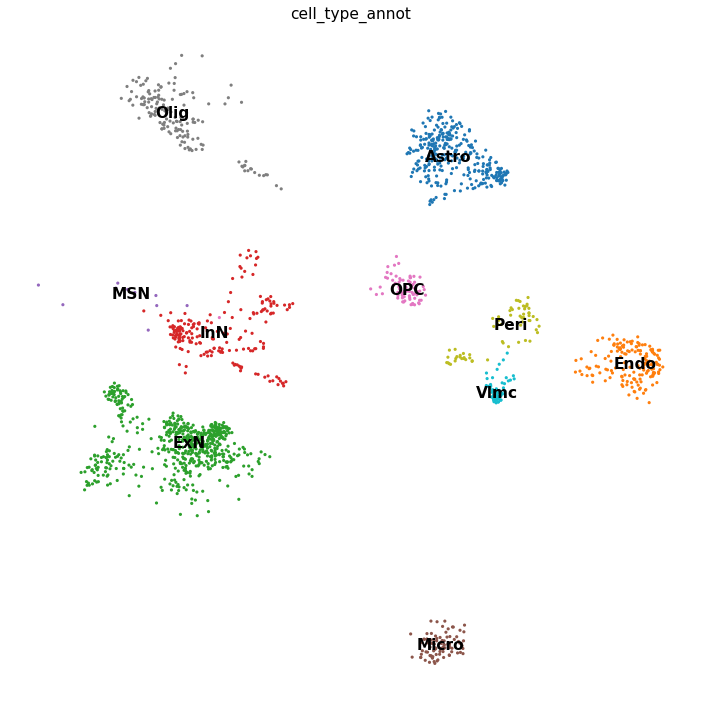

In [4]:
sns.set_context('paper',font_scale=1.6) 

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sc.pl.umap(
    sp_adata, color="cell_type_annot", size=40, frameon=False, show=False, ax=axs,legend_loc='on data'
)
plt.tight_layout()

In [5]:
color_dict = {'Astro': '#1f77b4',
 'Endo': '#aec7e8',
 'Epen': '#ffbb78',
 'ExN': '#98df8a',
 'InN': '#d62728',
 'MSN': '#ff7f0e',
 'Macro': '#9467bd',
 'Micro': '#ff9896',
 'OPC': '#e377c2',
 'Olig': '#c5b0d5',
 'Peri': '#8c564b',
 'T cell': '#c49c94',
 'Vlmc': '#17becf'}
labelnames = ['Astro',
 'Endo',
 'ExN',
 'InN',
 'MSN',
 'Micro',
 'OPC',
 'Olig',
 'Peri',
 'Vlmc']

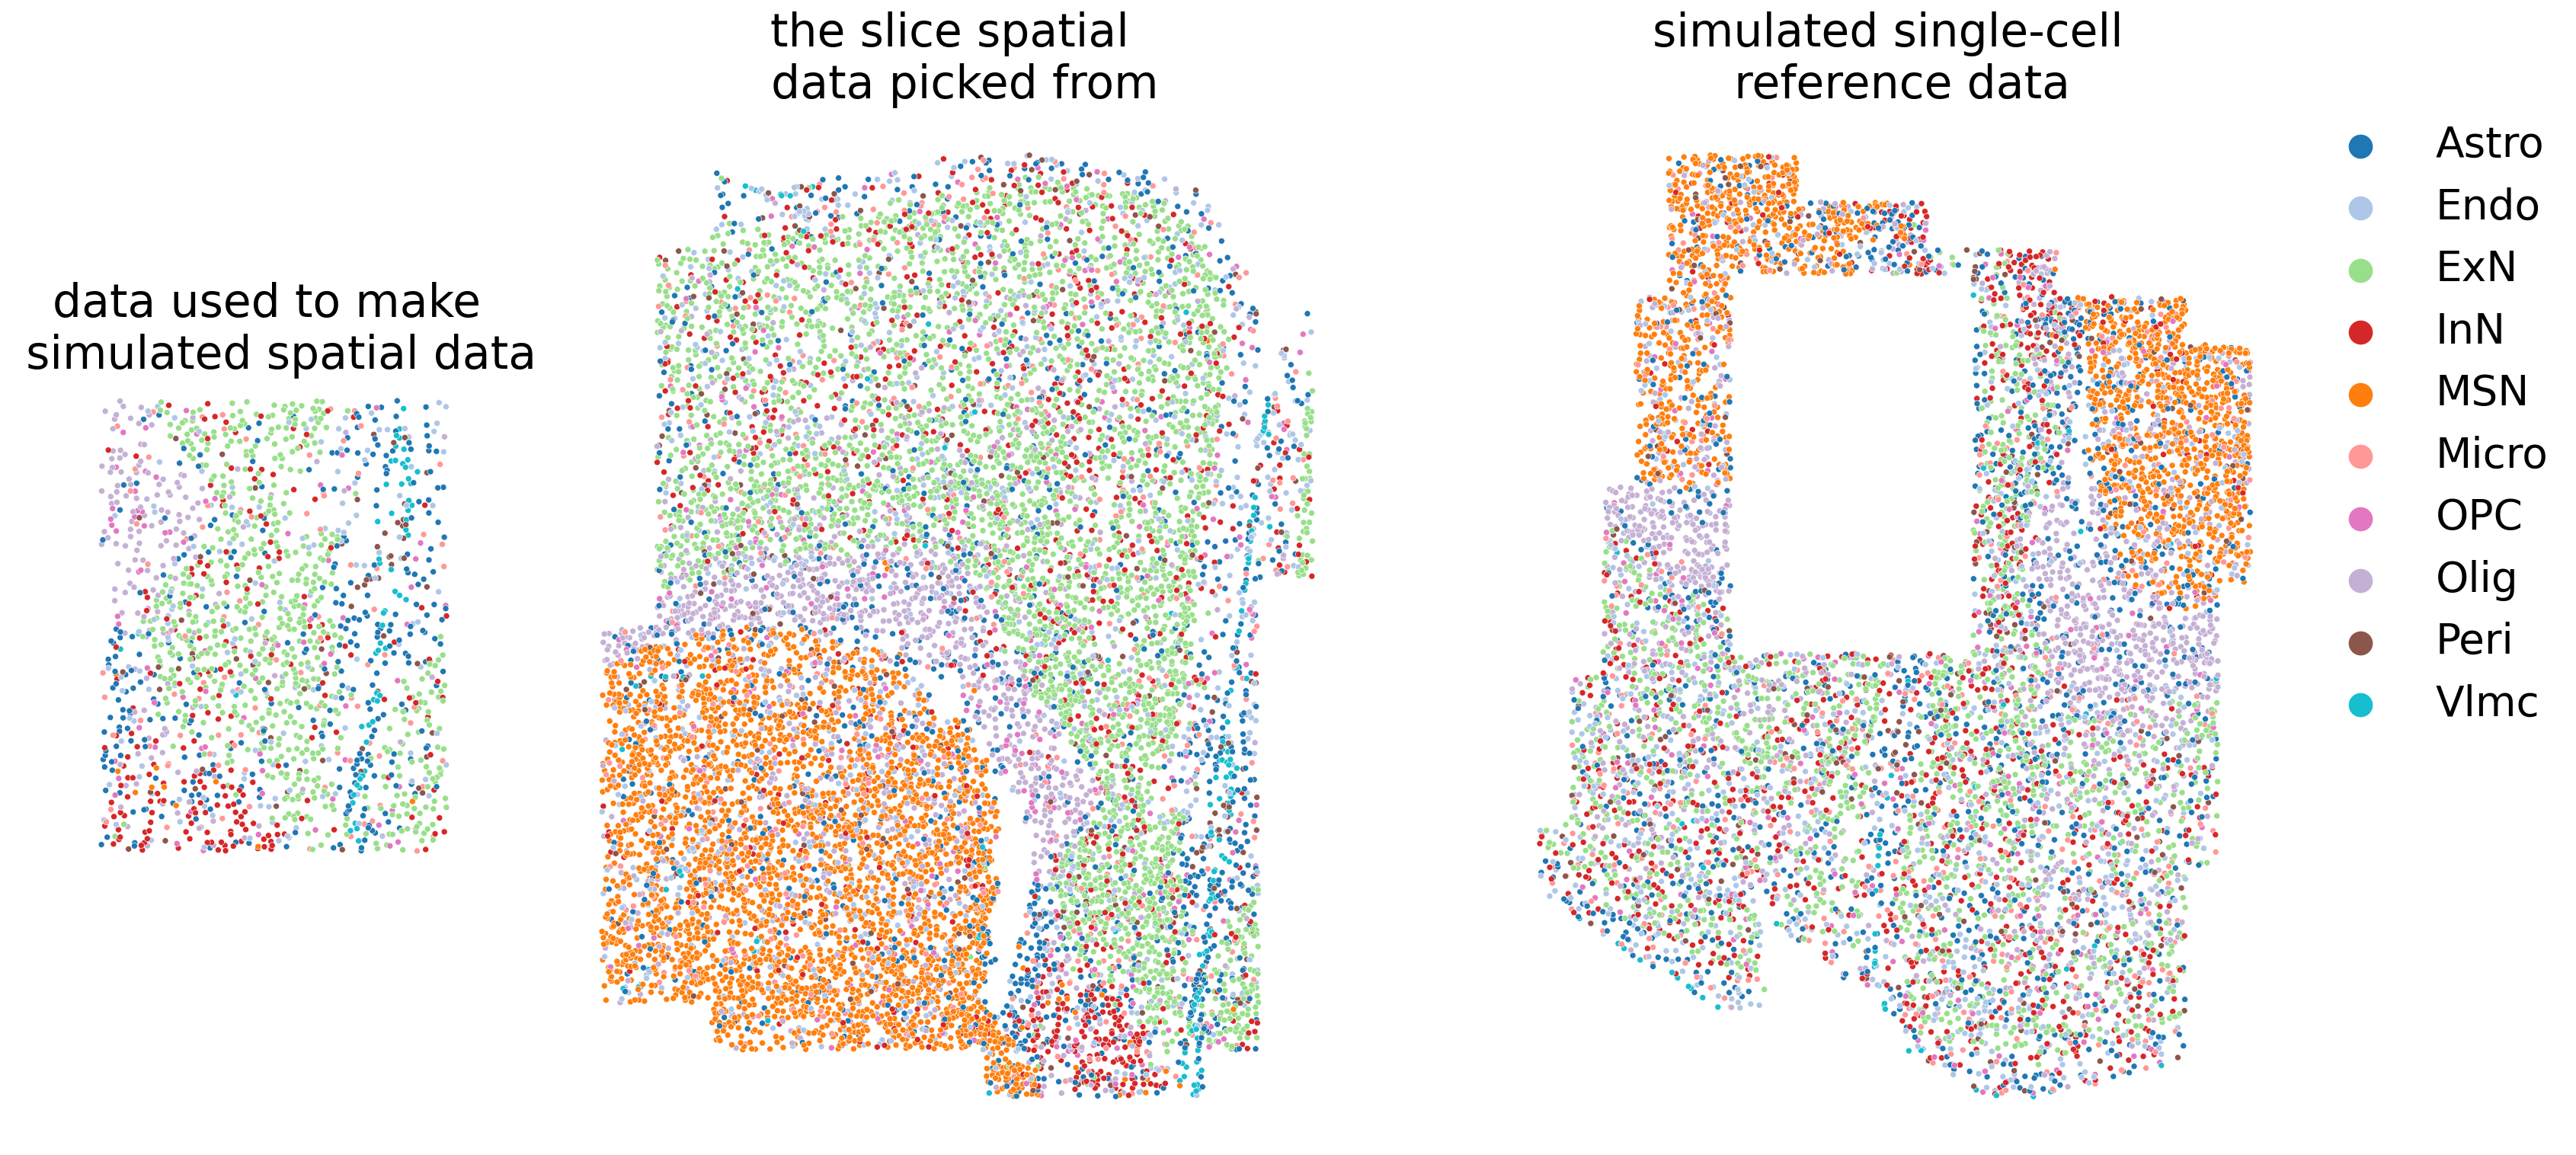

In [5]:
# visualize the data 
sns.set_context('paper',font_scale=3) 
plt.rcParams["legend.markerscale"] = 3

plt.figure(figsize=(30, 12),dpi = 150)
ax1 = plt.subplot(4,6,(8,14))
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
ax = [ax1, ax2, ax3]

sns.scatterplot(data=sp_adata.obs, x="x", y="y", hue='cell_type_annot', s = 15, palette = color_dict, ax = ax[0], legend = False)
ax[0].set_title('data used to make \n simulated spatial data')
ax[0].invert_yaxis()
ax[0].axis('off')
sns.scatterplot(data=sp_adata.uns['cell_locations'], x="x", y="y", hue='cell_type_annot', s = 15, palette = color_dict, ax = ax[1], legend = False)
ax[1].set_title('the slice spatial \n data picked from')
ax[1].invert_yaxis()
ax[1].axis('off')
# ax[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
# ax[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
sns.scatterplot(data=sc_adata.obs, x="x", y="y", hue='cell_type_annot', s = 15, palette = color_dict, ax = ax[2])
ax[2].set_title('simulated single-cell \n reference data')
ax[2].invert_yaxis()
ax[2].axis('off')
ax[2].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)

# Generate fake spatial data 

In [2]:
sp_adata = sc.read('../demo_data/MERFISH_MBA_sp_D8S1.h5ad')
sc_adata = sc.read('../demo_data/MERFISH_MBA_scref.h5ad')

sp_cell_class_column = cell_class_column = 'cell_type_annot'

In [3]:
x_min = sp_adata.obs['x'].min()
x_max = sp_adata.obs['x'].max()
y_min = sp_adata.obs['y'].min()
y_max = sp_adata.obs['y'].max()

num_x = 28
num_y = 42

# make grid 
x_seg = np.linspace(x_min, x_max, num_x)
y_seg = np.linspace(y_min, y_max, num_y)

print((x_min, x_max), (y_min, y_max))
print(y_max - y_min, x_max - x_min, (y_max - y_min) / (x_max - x_min))
print(x_seg[1] - x_seg[0], y_seg[1] - y_seg[0])

(-2877.362013593316, -2030.0560147315264) (-1999.8175437897444, -600.3079827427864)
1399.509561046958 847.3059988617897 1.651716809425354
31.381703661547817 34.13437953773064


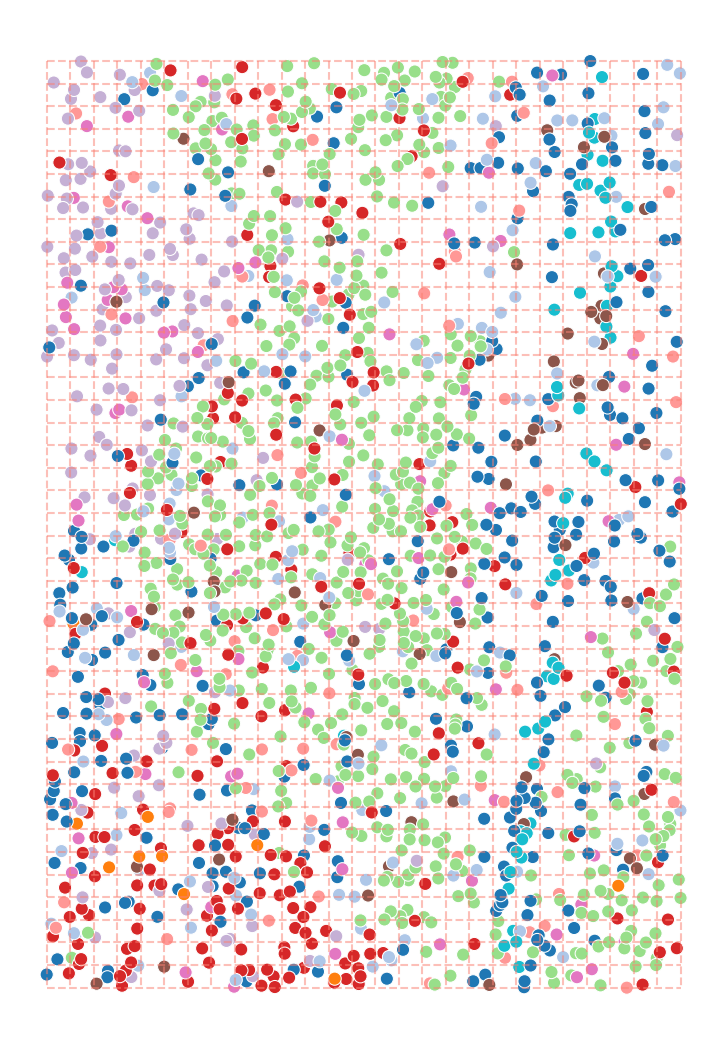

In [6]:
with mpl.rc_context({'figure.figsize': (6, 9), 'figure.dpi': 150}):
    ax = sns.scatterplot(data=sp_adata.obs, x="x", y="y", hue=sp_cell_class_column, s = 40, palette = color_dict, legend = False)
    ax.invert_yaxis()
    for i in range(x_seg.shape[0]):
        ax.plot([x_seg[i] for _ in y_seg],y_seg,linestyle='dashed', c = 'salmon', lw = 1, alpha = 0.5)
    for i in range(y_seg.shape[0]):    
        ax.plot(x_seg,[y_seg[i] for _ in x_seg],linestyle='dashed', c = 'salmon', lw = 1, alpha = 0.5)
#         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.axis('off')

<AxesSubplot:ylabel='Density'>

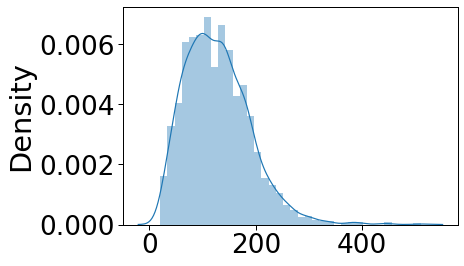

In [10]:
sns.distplot(sp_adata.X.sum(1))

In [7]:
mean_UMI = sp_adata.X.sum(1).mean()
print(mean_UMI)
sample_UMIs = [int(0.5 * mean_UMI), int(1.0 * mean_UMI), int(2.0 * mean_UMI)]
print(sample_UMIs)

base_path = '/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MBA_D8S1'
if not os.path.exists(base_path):
    os.mkdir(base_path)
base_path = os.path.join(base_path, str(num_x) + 'x' + str(num_y))
if not os.path.exists(base_path):
    os.mkdir(base_path)
base_path

127.95645
[63, 127, 255]


'/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MBA_D8S1/28x42'

In [13]:
for sample_UMI in sample_UMIs:
    spatial_adata =  sp_adata.copy()
    
    # create fake spatial data with 'cell_locations' in uns (We assume the truth cell number in each fake spot is known in simulation study, thus skip "Nuclei segmentation" step in SpatialScope)
    spatial_adata = add_spot_label(spatial_adata, x_seg, y_seg, location_X_column = 'x', location_Y_column = 'y')
    generated_spot_adata = generate_spot_adata_func(spatial_adata, sample_UMI = sample_UMI)
    print(f'cell number range: {np.unique(generated_spot_adata.obs.cell_nums)}')

    temp_obs = rename_cell_locations_obs(spatial_adata)
    generated_spot_adata.uns['cell_locations'] = temp_obs

    # filter spot that UMI counts smaller than 20
    generated_spot_adata_filtered = generated_spot_adata.copy()[~(generated_spot_adata.X.sum(1) < 20)]

    index = ~generated_spot_adata.uns['cell_locations']['spot_index_int'].isin(np.where(generated_spot_adata.X.sum(1) < 20)[0])
    generated_spot_adata_filtered.uns['cell_locations'] = generated_spot_adata.uns['cell_locations'][index].copy()
    
    
    # save data 
    save_data_dir = os.path.join(base_path, f'{int(sample_UMI)}UMI')
    if not os.path.exists(save_data_dir):
        os.mkdir(save_data_dir)
    ## spatial
    generated_spot_adata_filtered.obsm['spatial'] = generated_spot_adata_filtered.obs[['x','y']].values
    generated_spot_adata_filtered.obs_names_make_unique()
    generated_spot_adata_filtered.var_names_make_unique()
    save_sp_dir = os.path.join(save_data_dir, 'spatial.h5ad')
    print(f'saved simulated spatial data of subsample {sample_UMI} UMI in {save_sp_dir}')
    generated_spot_adata_filtered.write(save_sp_dir)

cell number range: [1 2 3 4 5]
saved simulated spatial data of subsample 63 UMI in /home/share/xwanaf/sour_sep/revision/data/RCTDnv_MBA_D8S1/28x42/63UMI/spatial.h5ad
cell number range: [1 2 3 4 5]
saved simulated spatial data of subsample 127 UMI in /home/share/xwanaf/sour_sep/revision/data/RCTDnv_MBA_D8S1/28x42/127UMI/spatial.h5ad
cell number range: [1 2 3 4 5]
saved simulated spatial data of subsample 255 UMI in /home/share/xwanaf/sour_sep/revision/data/RCTDnv_MBA_D8S1/28x42/255UMI/spatial.h5ad


In [14]:
generated_spot_adata_filtered.obs.cell_nums.value_counts()

1    344
2    325
3    166
4     54
5     12
Name: cell_nums, dtype: int64

# SpatialScope
```
for rep in {0..9}

do 

for i in 0.000001 5 10 20 30 40 50 60 70 80 90 100 120 150 200 500 1000

do

python ./src/Cell_Type_Identification.py \
--cell_class_column cell_type_annot \
--tissue "rep$rep" \
--out_dir /home/share/xwanaf/sour_sep/revision/data/RCTDnv_MBA_D8S1/28x42/127UMI \
--ST_Data /home/share/xwanaf/sour_sep/revision/data/RCTDnv_MBA_D8S1/28x42/127UMI/spatial.h5ad \
--SC_Data ../demo_data/MERFISH_MBA_scref.h5ad \
--hs_ST \
--UMI_min_sigma 100 \
--nu $i

done
done

```
# StarDist + RCTD 
```
for rep in {0..9}

do 

python ./compared_methods/SDRCTD.py \
--out_dir /home/share/xwanaf/sour_sep/revision/data/RCTDnv_MBA_D8S1/28x42/127UMI/rep$rep \
--ST_Data /home/share/xwanaf/sour_sep/revision/data/RCTDnv_MBA_D8S1/28x42/127UMI/spatial.h5ad \
--SC_Data ../demo_data/MERFISH_MBA_scref.h5ad \
--cell_class_column cell_type_annot \
--cell_num_column cell_nums \
--hs_ST \

done
```

# Vis Results

In [8]:
DataDir = os.path.join(base_path, str(sample_UMIs[1]) + 'UMI')
sp_adata = sc.read(os.path.join(DataDir, 'spatial.h5ad'))

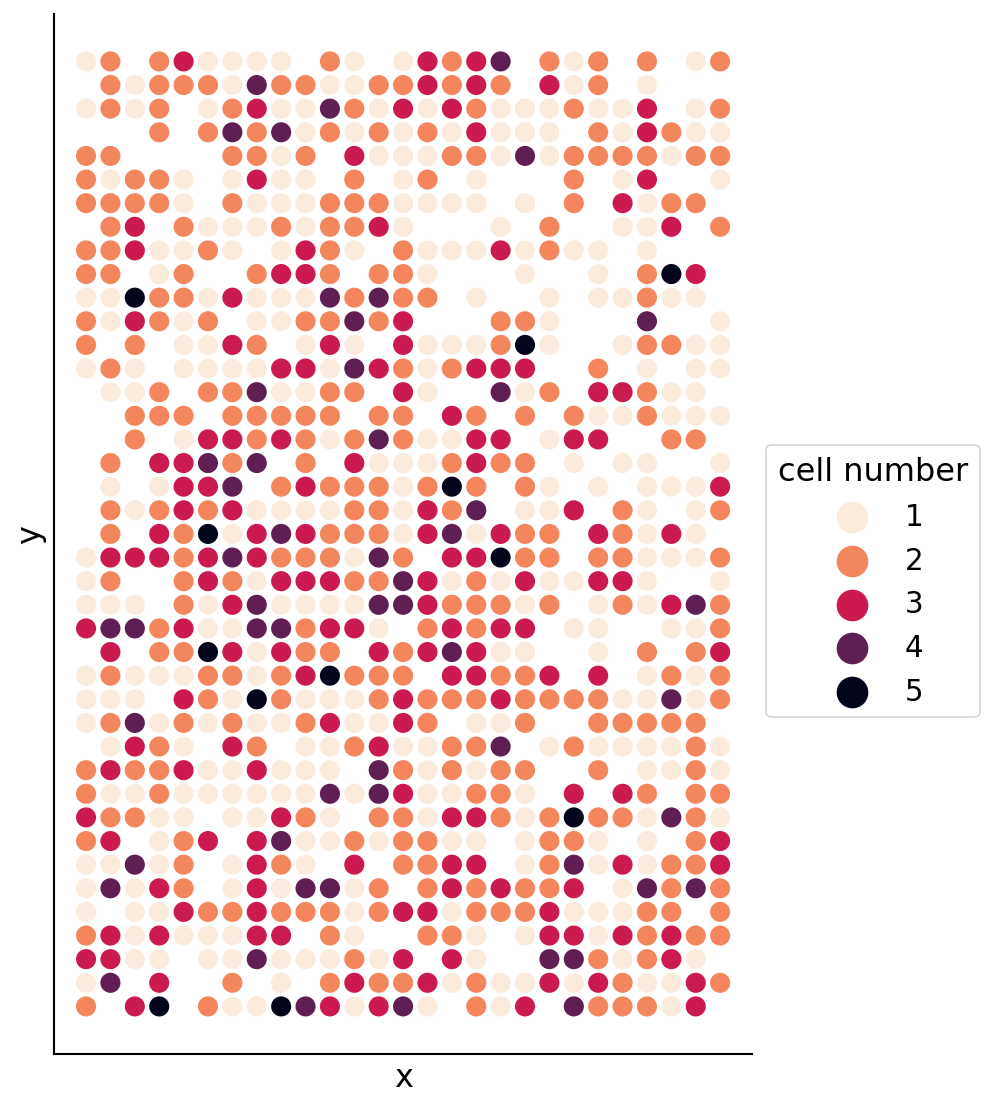

In [52]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('default')

sns.set_context('paper',font_scale=1.6) 

with mpl.rc_context({'figure.figsize': (6, 9), 'figure.dpi': 150}):
    ax = sns.scatterplot(data=sp_adata.obs, x="x", y="y", hue='cell_nums', s = 110, palette = "rocket_r")
#     ax = sns.scatterplot(data=sp_adata.obs, x="X", y="Y", s = 50, palette = "rocket_r")
    ax.invert_yaxis()
    ax.set_xticklabels('')
    ax.set_xticks([])
    ax.set_yticklabels('')
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.legend(bbox_to_anchor=(1,0.6), title = 'cell number', markerscale = 3)

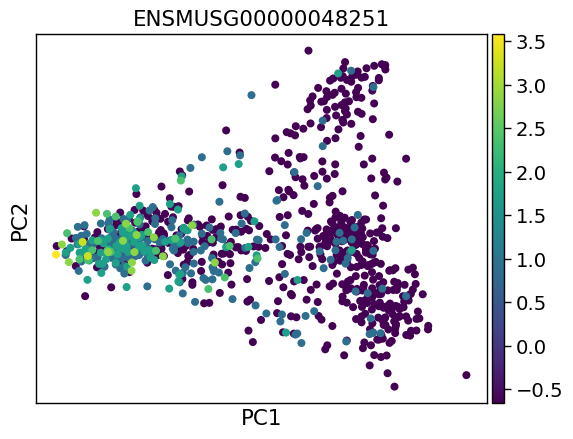

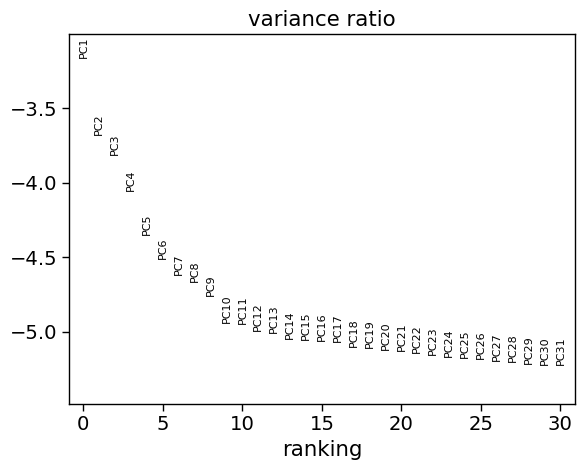

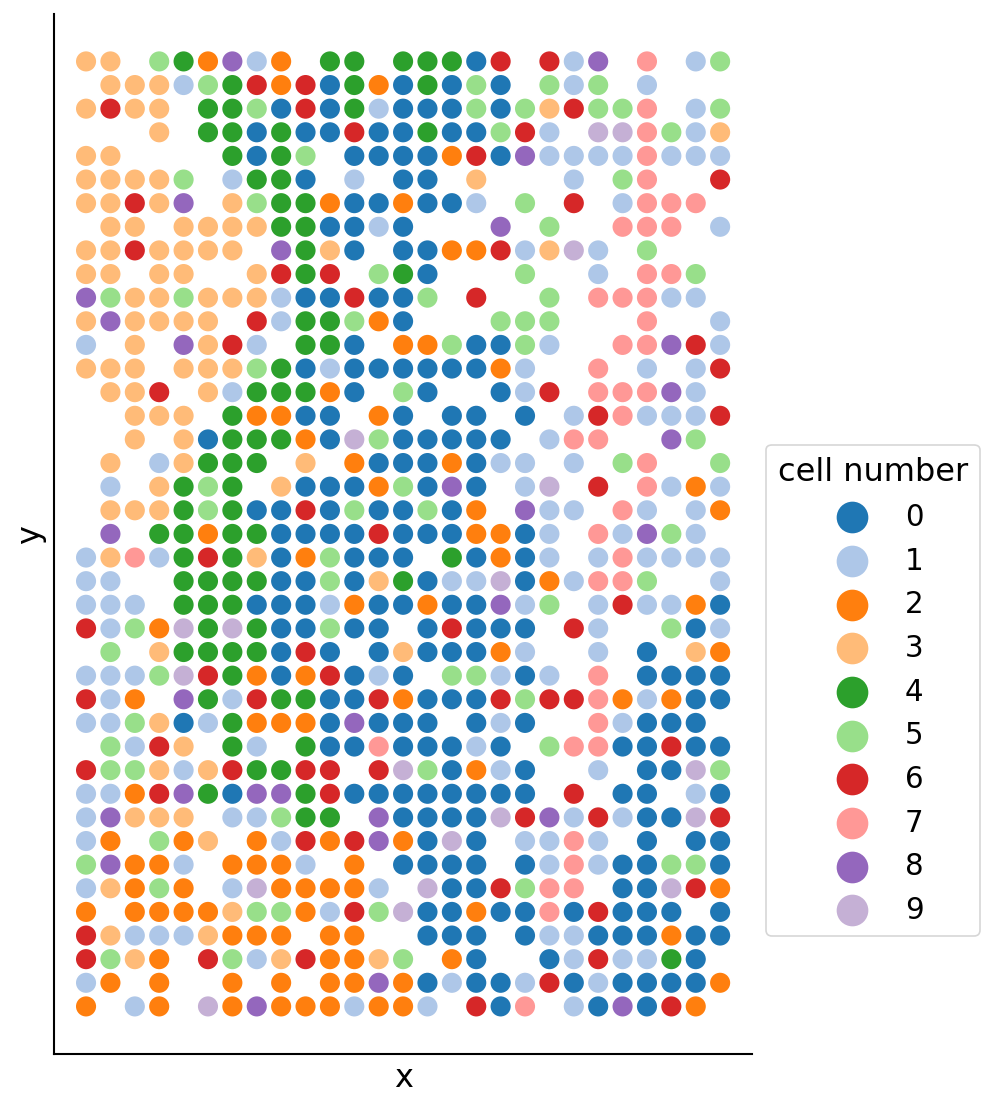

In [53]:
leiden_sp = sp_adata.copy()

sc.pp.log1p(leiden_sp)
sc.pp.scale(leiden_sp, max_value=10)
sc.tl.pca(leiden_sp, svd_solver='arpack')
sc.pl.pca(leiden_sp, color=sp_adata.var.index[10])
sc.pl.pca_variance_ratio(leiden_sp, log=True)
sc.pp.neighbors(leiden_sp, n_neighbors=10, n_pcs=40)
sc.tl.leiden(leiden_sp)

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('default')

sns.set_context('paper',font_scale=1.6) 

with mpl.rc_context({'figure.figsize': (6, 9), 'figure.dpi': 150}):
    ax = sns.scatterplot(data=leiden_sp.obs, x="x", y="y", hue='leiden', s = 110, palette = 'tab20')
#     ax = sns.scatterplot(data=sp_adata.obs, x="X", y="Y", s = 50, palette = "rocket_r")
    ax.invert_yaxis()
    ax.set_xticklabels('')
    ax.set_xticks([])
    ax.set_yticklabels('')
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.legend(bbox_to_anchor=(1,0.6), title = 'leiden cluster', markerscale = 3)

In [23]:
DataDir

'/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MOp/260UMI'

In [25]:
DataDir = os.path.join(base_path, str(sample_UMIs[1]) + 'UMI')
sp_adata = sc.read(os.path.join(DataDir, 'spatial.h5ad'))

## nu test

In [26]:
def ssim(im1,im2,M=1):
    im1, im2 = im1/im1.max(), im2/im2.max()
    mu1 = im1.mean()
    mu2 = im2.mean()
    sigma1 = np.sqrt(((im1 - mu1) ** 2).mean())
    sigma2 = np.sqrt(((im2 - mu2) ** 2).mean())
    sigma12 = ((im1 - mu1) * (im2 - mu2)).mean()
    k1, k2, L = 0.01, 0.03, M
    C1 = (k1*L) ** 2
    C2 = (k2*L) ** 2
    C3 = C2/2
    l12 = (2*mu1*mu2 + C1)/(mu1 ** 2 + mu2 ** 2 + C1)
    c12 = (2*sigma1*sigma2 + C2)/(sigma1 ** 2 + sigma2 ** 2 + C2)
    s12 = (sigma12 + C3)/(sigma1*sigma2 + C3)
    ssim = l12 * c12 * s12
    return ssim

def rmse(x1,x2):
    return mean_squared_error(x1,x2,squared=False)
def mae(x1,x2):
    return np.mean(np.abs(x1-x2))

from collections.abc import Iterable
def compare_results(gd,result_list,metric='pcc',columns=None,axis=1):
    if metric=='pcc':
        func = pearsonr
        r_ind = 0
    if metric=='mae':
        func = mae
        r_ind = None
    if metric=='jsd':
        func = jensenshannon
        r_ind = None
    if metric=='rmse':
        func = rmse
        r_ind = None
    if metric=='ssim':
        func = ssim
        r_ind = None
    if isinstance(result_list, pd.DataFrame):
        c_list = []
        if axis == 1:
            print('axis: ',1)
            for i,c in enumerate(gd.columns):
                r = func(gd.iloc[:,i].values, np.clip(result_list.iloc[:,i],0,1))
                if isinstance(result_list, Iterable):
                    if r_ind is not None:
                        r = r[r_ind]
                c_list.append(r)
        else:
            print('axis: ',0)
            for i,c in enumerate(gd.index):
                r = func(gd.iloc[i,:].values, np.clip(result_list.iloc[i,:],0,1))
                if isinstance(result_list, Iterable):
                    if r_ind is not None:
                        r = r[r_ind]
                c_list.append(r)
        df = pd.DataFrame(c_list,index=gd.columns,columns=columns)
    else:
        df_list = []
        for res in result_list:
            c_list = []
            if axis == 1:
                for i,c in enumerate(gd.columns):
                    r = func(gd.iloc[:,i].values, np.clip(res.iloc[:,i],0,1))
                    if isinstance(res, Iterable):
                        if r_ind is not None:
                            r = r[r_ind]
                    c_list.append(r)
                df_tmp = pd.DataFrame(c_list,index=gd.columns)
            else:
                for i,c in enumerate(gd.index):
                    r = func(gd.iloc[i,:].values, np.clip(res.iloc[i,:],0,1))
                    if isinstance(res, Iterable):
                        if r_ind is not None:
                            r = r[r_ind]
                    c_list.append(r)
                df_tmp = pd.DataFrame(c_list,index=gd.index)
            df_list.append(df_tmp)
        df = pd.concat(df_list,axis=1)
        df.columns = columns
    return df


In [27]:
def label_to_matrix(spot_label, label):
    matrix = pd.DataFrame(index = np.unique(spot_label), columns = np.unique(np.array(label)))
    for i in np.unique(spot_label):
        each_spot_prop_df = pd.DataFrame(index = np.unique(np.array(label)))
        each_spot_prop_df['prop'] = np.zeros(each_spot_prop_df.shape[0])
        index = spot_label == i
        val, counts = np.unique(label[index], return_counts=True)
        each_spot_prop_df.loc[val, 'prop'] = counts
        matrix.loc[i,:] = each_spot_prop_df.values.squeeze()

    return matrix

gd_results = label_to_matrix(np.array(sp_adata.uns['cell_locations']['spot_index_int']), np.array(sp_adata.uns['cell_locations'][sp_cell_class_column]))
gd_results = (gd_results.T/gd_results.sum(axis=1)).T
gd_results = gd_results.fillna(0)

In [28]:
nu_list = [0.000001, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000] + ['RCTD']

error_rate_df = pd.DataFrame(columns = {'error_rate', 'nu', 'rep'})
decon_df = pd.DataFrame()
decon_pcc_df = pd.DataFrame()
decon_rmse_df = pd.DataFrame()

for j, nu in enumerate(nu_list):
    for i, rep in enumerate(range(10)):
        print(f"nu = {nu}; rep = {rep}")
        
        with open(os.path.join(DataDir, 'rep' + str(rep), 'InitProp.pickle'), 'rb') as handle:
            InitProp = pickle.load(handle)

        RCTD_results = (InitProp['results'] / np.array(InitProp['results'].sum(1))[:, None])
        RCTD_results = RCTD_results.loc[:, np.unique(RCTD_results.columns)]
        if rep == 0:
            print(os.path.join(DataDir, 'rep' + str(rep), 'RCTD_results.txt'))
            RCTD_results.to_csv(os.path.join(DataDir, 'rep' + str(rep), 'RCTD_results.txt'))
            
        
        SR_results = sc.read(os.path.join(DataDir, 'rep' + str(rep), 'SDRCTD_results/single_cell_type_label_bySDRCTD.h5ad'))
        SR_cell_type_label = SR_results.uns['cell_locations'].copy()
        prop = label_to_matrix(np.array(SR_cell_type_label['spot_index_int']), np.array(SR_cell_type_label['SDRCTD_cell_type']))
        prop = prop/prop.sum(1)[:,None]

        SR_results = prop
        SR_results.index = np.arange(len(SR_results))
        SR_results = SR_results.loc[:,np.unique(SR_results.columns)]

        if rep == 0:
            print(os.path.join(DataDir, 'rep' + str(rep), 'SR_results.txt'))
            SR_results.to_csv(os.path.join(DataDir, 'rep' + str(rep), 'SR_results.txt'))
            
        if nu == 'RCTD':  
            estimated = np.array(SR_cell_type_label['SDRCTD_cell_type'])
            estimated = np.array([_.replace('_','/') for _ in estimated])
            tl = np.array(SR_cell_type_label[sp_cell_class_column])
            error_index = tl != estimated
            SR_cell_type_label['error'] = (error_index).astype(int) 
            RCTD_error_rate = np.where((error_index).astype(int) == 1)[0].shape[0]/ error_index.shape[0]
            error_rate_df.loc[len(error_rate_df.index)] = {'error_rate': RCTD_error_rate, 'nu': nu, 'rep': int(rep)}
        else:
            # palette = ['#F0EFF6', '#D0E2F8', '#c44e52']
            cell_locations = pd.read_csv(os.path.join(DataDir, 'rep' + str(rep), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

            prop = label_to_matrix(np.array(cell_locations['spot_index_int']), np.array(cell_locations['discrete_label_ct']))
            prop = prop/prop.sum(1)[:,None]

            SpatialScope_results = prop
            SpatialScope_results.index = np.arange(len(RCTD_results))
            SpatialScope_results = SpatialScope_results.loc[:,np.unique(SpatialScope_results.columns)]
            print(os.path.join(DataDir, 'rep' + str(rep), 'SpatialScope_result'+ '_nu' + str(nu) +'.txt'))
            SpatialScope_results.to_csv(os.path.join(DataDir, 'rep' + str(rep), 'SpatialScope_result'+ '_nu' + str(nu) +'.txt'))

            RCTD_results = RCTD_results.loc[:,gd_results.columns]
            SR_results = SR_results.loc[:,gd_results.columns]
            SpatialScope_results = SpatialScope_results.loc[:,gd_results.columns]            
            
            starmap_spots_pcc = compare_results(
                gd_results,
                [RCTD_results,SR_results, SpatialScope_results],
                columns = ['RCTD', 'SR', 'SpatialScope'],
                axis=0,
                metric='pcc'
            )

            starmap_spots_rmse = compare_results(
                gd_results,
                [RCTD_results,SR_results, SpatialScope_results],
                columns = ['RCTD', 'SR', 'SpatialScope'],
                axis=0,
                metric='rmse'
            )

            starmap_spots_pcc['nu'] = [int(nu)] * starmap_spots_pcc.shape[0]
            starmap_spots_pcc['metric'] = ['pcc'] * starmap_spots_pcc.shape[0]
            starmap_spots_rmse['nu'] = [int(nu)] * starmap_spots_rmse.shape[0]
            starmap_spots_rmse['metric'] = ['rmse'] * starmap_spots_rmse.shape[0]
            
            starmap_spots_pcc['cell_nums'] = starmap_spots_rmse['cell_nums'] = sp_adata.obs.cell_nums.tolist()

            decon_df = pd.concat([decon_df, starmap_spots_pcc, starmap_spots_rmse], axis = 0)
            decon_pcc_df = pd.concat([decon_pcc_df, starmap_spots_pcc], axis = 0)
            decon_rmse_df = pd.concat([decon_rmse_df, starmap_spots_rmse], axis = 0)


            estimated = np.array(cell_locations['discrete_label_ct'])
            estimated = np.array([_.replace('_','/') for _ in estimated])
            tl = np.array(cell_locations[sp_cell_class_column])
            error_index = tl != estimated
            cell_locations['error'] = (error_index).astype(int) 
            error_rate = np.where((error_index).astype(int) == 1)[0].shape[0]/ error_index.shape[0]
            error_rate_df.loc[len(error_rate_df.index)] = {'error_rate': error_rate, 'nu': int(nu), 'rep': int(rep)}               
        

nu = 1e-06; rep = 0
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MBA_D8S1/28x42/127UMI/rep0/RCTD_results.txt
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MBA_D8S1/28x42/127UMI/rep0/SR_results.txt
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MBA_D8S1/28x42/127UMI/rep0/SpatialScope_result_nu1e-06.txt
nu = 1e-06; rep = 1
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MBA_D8S1/28x42/127UMI/rep1/SpatialScope_result_nu1e-06.txt
nu = 1e-06; rep = 2
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MBA_D8S1/28x42/127UMI/rep2/SpatialScope_result_nu1e-06.txt
nu = 1e-06; rep = 3
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MBA_D8S1/28x42/127UMI/rep3/SpatialScope_result_nu1e-06.txt
nu = 1e-06; rep = 4
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MBA_D8S1/28x42/127UMI/rep4/SpatialScope_result_nu1e-06.txt
nu = 1e-06; rep = 5
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MBA_D8S1/28x42/127UMI/rep5/SpatialScope_result_nu1e-06.txt
nu = 1e-06; rep = 6
/home/share/xwanaf/sour_sep/

In [29]:
decon_df.to_csv(os.path.join(DataDir, 'decon_df.csv'))
error_rate_df.to_csv(os.path.join(DataDir, 'error_rate_df.csv'))

## error rate 

In [31]:
vis_nu_list = [0, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000] + ['StarDist \n + RCTD']

In [39]:
error_rate_df

rep    nu  error_rate
0      0     0    0.346719
1      1     0    0.351810
2      2     0    0.341063
3      3     0    0.349548
4      4     0    0.350679
..   ...   ...         ...
175    5  RCTD    0.338235
176    6  RCTD    0.334276
177    7  RCTD    0.340498
178    8  RCTD    0.355769
179    9  RCTD    0.352941

[180 rows x 3 columns]

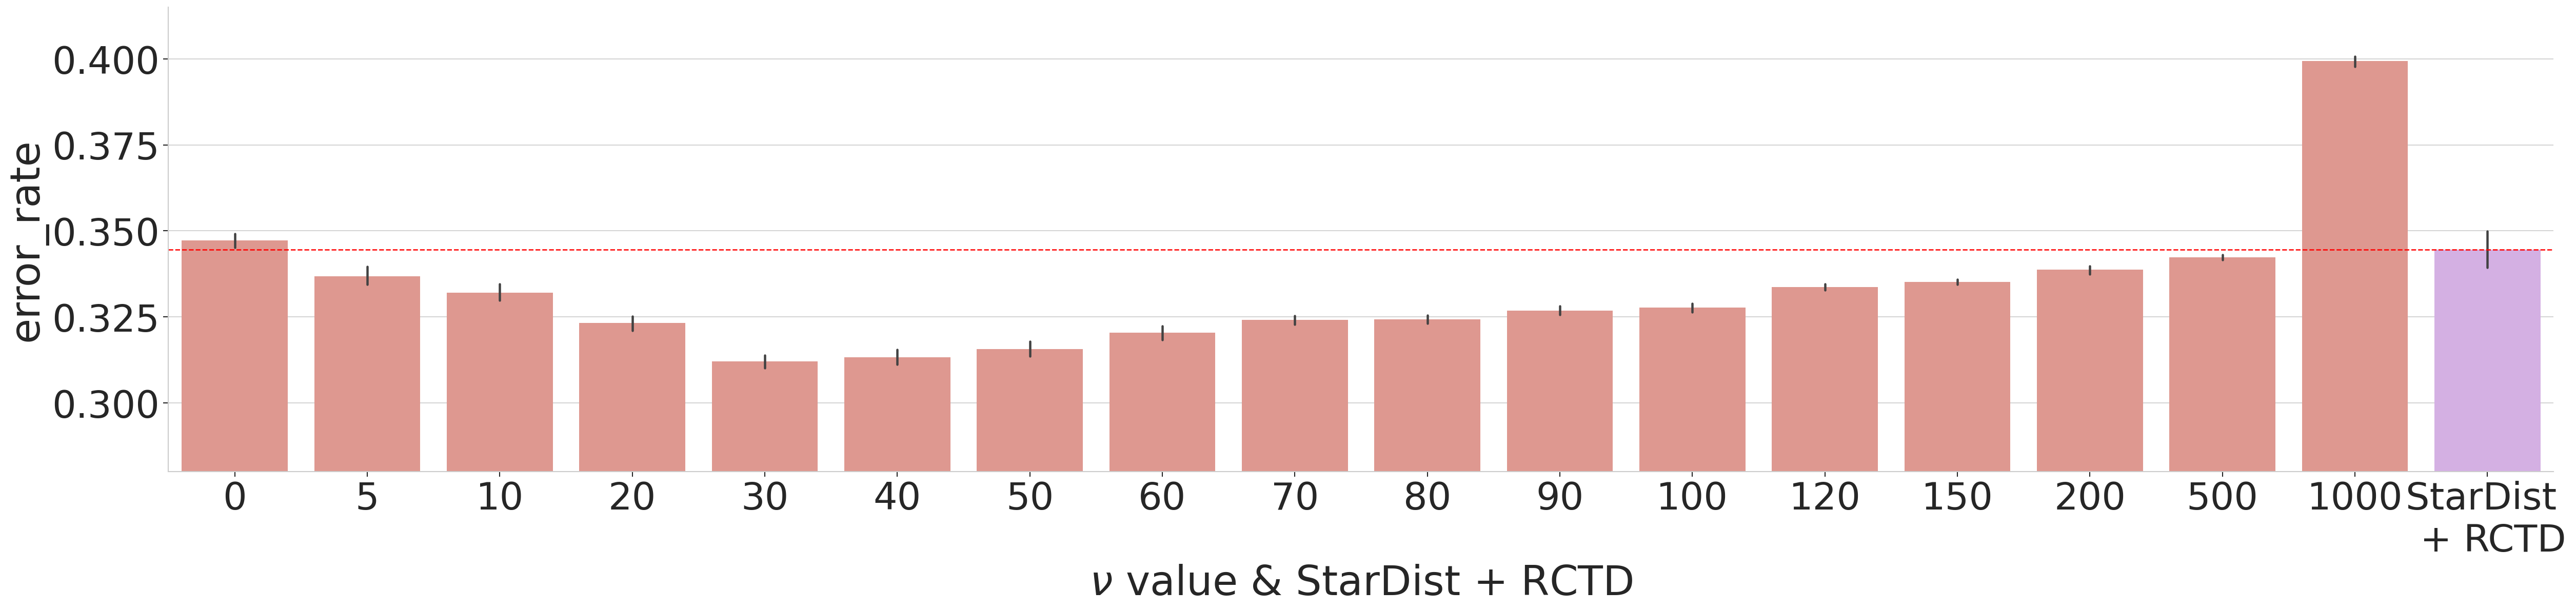

In [59]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=4) 
fig, ax = plt.subplots(1,1, figsize = (40, 8), dpi = 150)
plt.subplots_adjust(hspace = 0.5)


palette = ['#EB8E83'] * (len(vis_nu_list) - 1) + ['#D8A8EB']
with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="error_rate",hue='subsample',data=vis_df[(vis_df['correct_label'])&(vis_df['cell_num']==1)], palette="Set3", ax = ax)
    sns.barplot(x="nu", y="error_rate",data=error_rate_df, palette=palette, ax = ax)
ax.set_ylim(0.28,0.415)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(vis_nu_list)

plt.xlabel(r'$\nu$ value & StarDist + RCTD')
plt.axhline(y=error_rate_df[error_rate_df['nu'] == 'RCTD'].error_rate.mean(), color='r', linestyle='--')
plt.show()

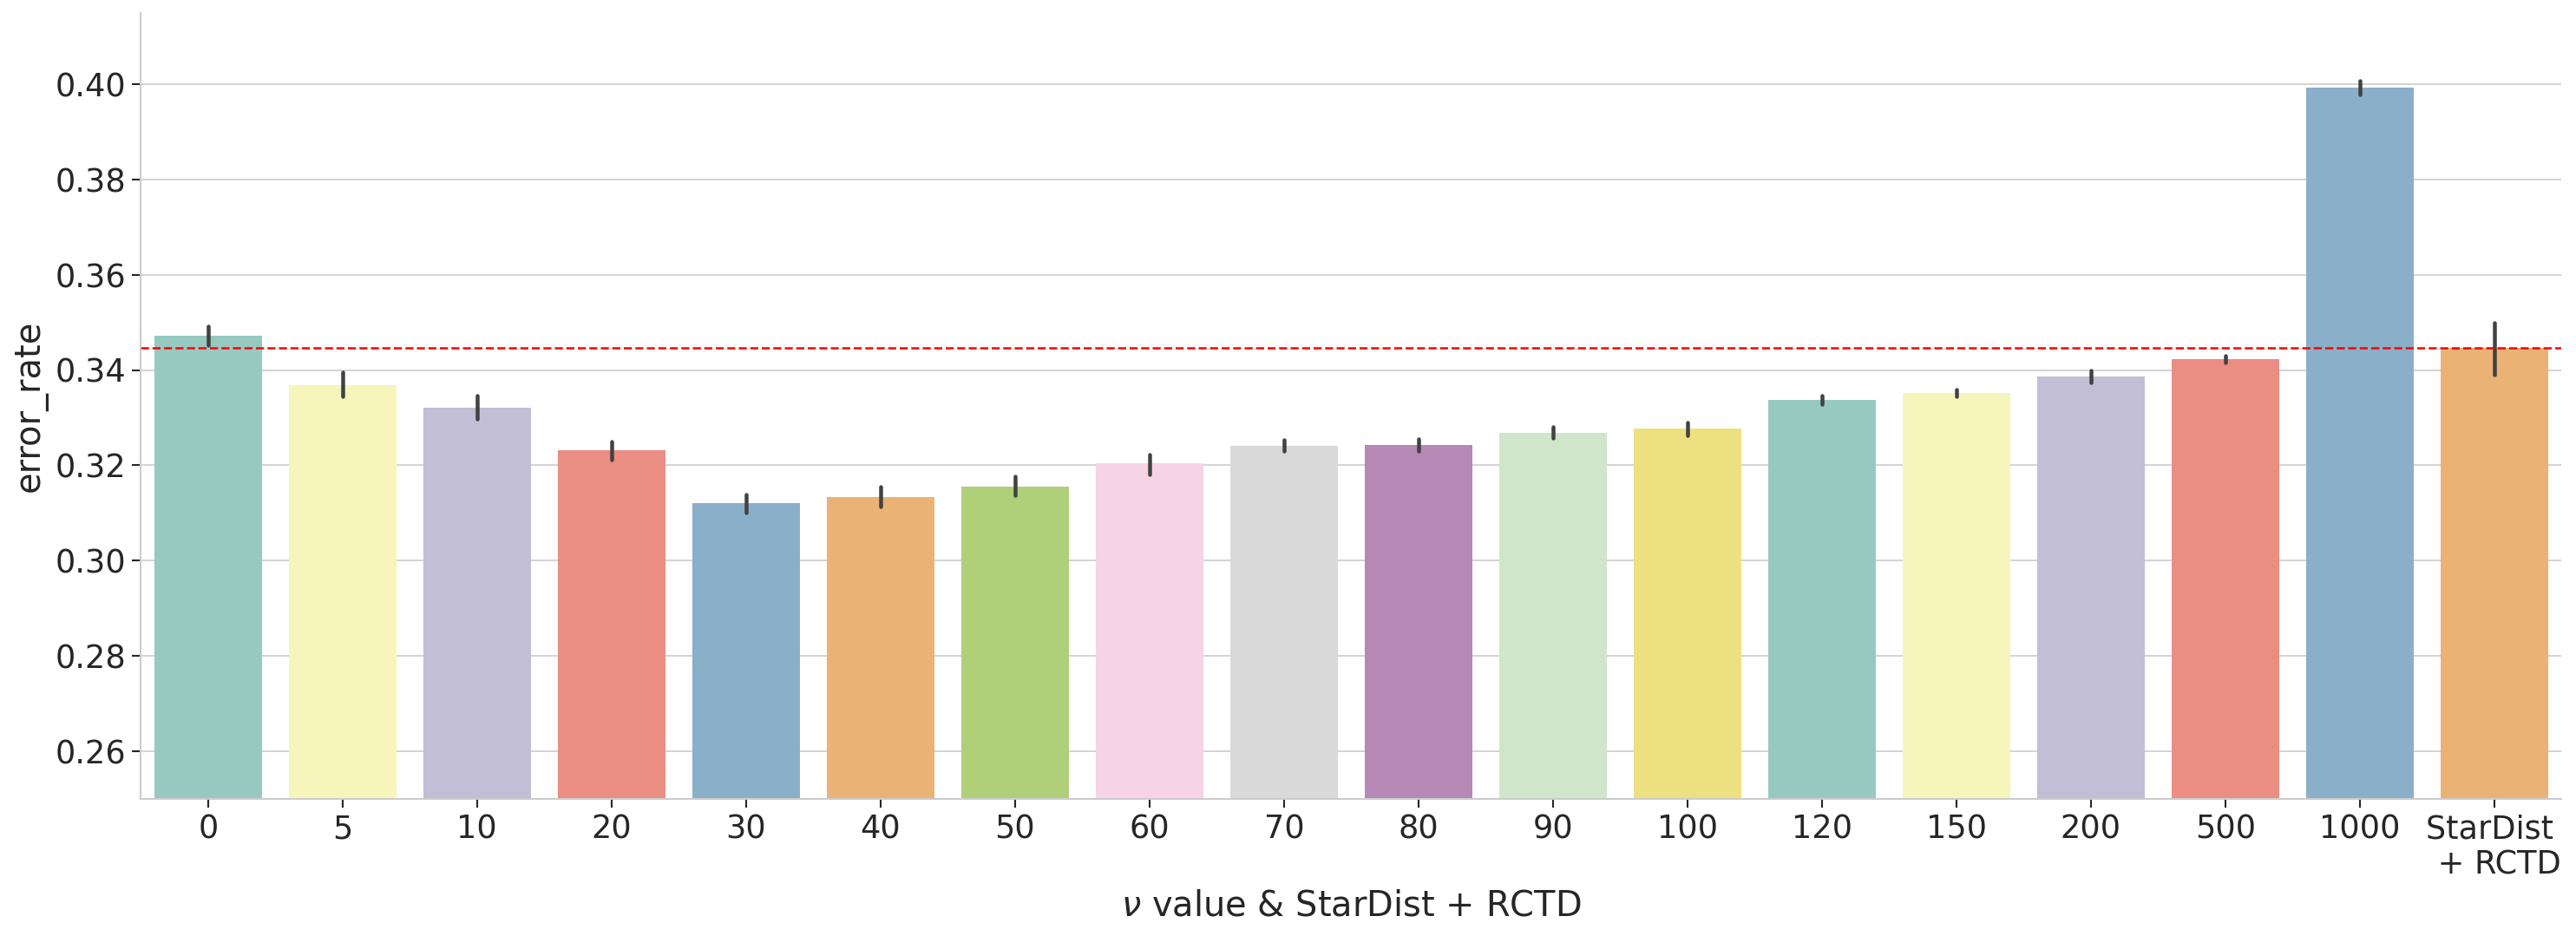

In [38]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (24, 8), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="error_rate",hue='subsample',data=vis_df[(vis_df['correct_label'])&(vis_df['cell_num']==1)], palette="Set3", ax = ax)
    sns.barplot(x="nu", y="error_rate",data=error_rate_df, palette="Set3", ax = ax)
ax.set_ylim(0.25,0.415)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(vis_nu_list)

plt.xlabel(r'$\nu$ value & StarDist + RCTD')
plt.axhline(y=error_rate_df[error_rate_df['nu'] == 'RCTD'].error_rate.mean(), color='r', linestyle='--')
plt.show()

## deconvolution


In [9]:
decon_df = pd.read_csv(os.path.join(DataDir, 'decon_df.csv'), index_col = 0)

In [10]:
vis_decon_df = pd.DataFrame()
vis_decon_df['value'] = decon_df.RCTD.tolist() + decon_df.SR.tolist() + decon_df.SpatialScope.tolist()
vis_decon_df['method'] = ['RCTD'] * decon_df.shape[0] + ['StarDist+RCTD'] * decon_df.shape[0] + ['SpatialScope'] * decon_df.shape[0]
vis_decon_df['nu'] = decon_df.nu.tolist() * 3
vis_decon_df['metric'] = decon_df.metric.tolist() * 3

In [11]:
vis_decon_df

value        method    nu metric
0       1.000000          RCTD     0    pcc
1       1.000000          RCTD     0    pcc
2       0.776160          RCTD     0    pcc
3       0.999855          RCTD     0    pcc
4       0.999847          RCTD     0    pcc
...          ...           ...   ...    ...
919015  0.000000  SpatialScope  1000   rmse
919016  0.223607  SpatialScope  1000   rmse
919017  0.000000  SpatialScope  1000   rmse
919018  0.223607  SpatialScope  1000   rmse
919019  0.000000  SpatialScope  1000   rmse

[919020 rows x 4 columns]

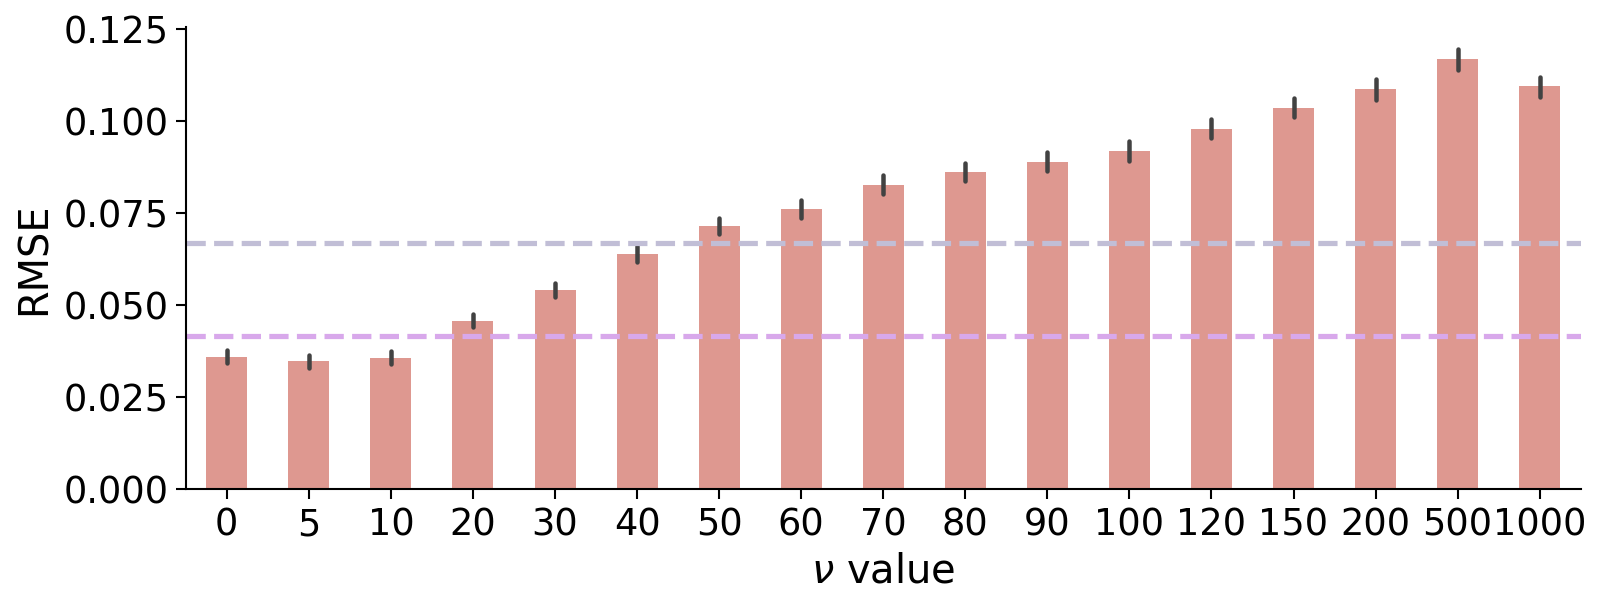

In [30]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
# plt.style.use('seaborn-whitegrid')
plt.style.use('default')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (12, 4), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="value",hue='method',data=vis_decon_df[(vis_decon_df.metric == 'rmse')], palette=['#C1BED6', '#D8A8EB', '#EB8E83'], ax = ax)
    sns.barplot(x="nu", y="value",data=vis_decon_df[(vis_decon_df.metric == 'rmse') & (vis_decon_df['method'] == 'SpatialScope')], width = 0.5, palette=['#EB8E83'], ax = ax)
# ax.set_ylim(0.4,0.95)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.legend(bbox_to_anchor=(1,0.6))
# ax.legend_.remove()
#ax.set_yticks([0.84, 0.86, 0.88])
#ax.set_xticklabels(['130 UMIs','260 UMIs','520 UMIs'])
plt.axhline(y=vis_decon_df[(vis_decon_df['method'] == 'RCTD') & (vis_decon_df['metric'] == 'rmse')].value.mean(), color='#C1BED6', linestyle='--', linewidth = 2.5)
plt.axhline(y=vis_decon_df[(vis_decon_df['method'] == 'StarDist+RCTD') & (vis_decon_df['metric'] == 'rmse')].value.mean(), color='#D8A8EB', linestyle='--', linewidth = 2.5)
plt.ylabel('RMSE')
plt.xlabel(r'$\nu$ value')
plt.show()

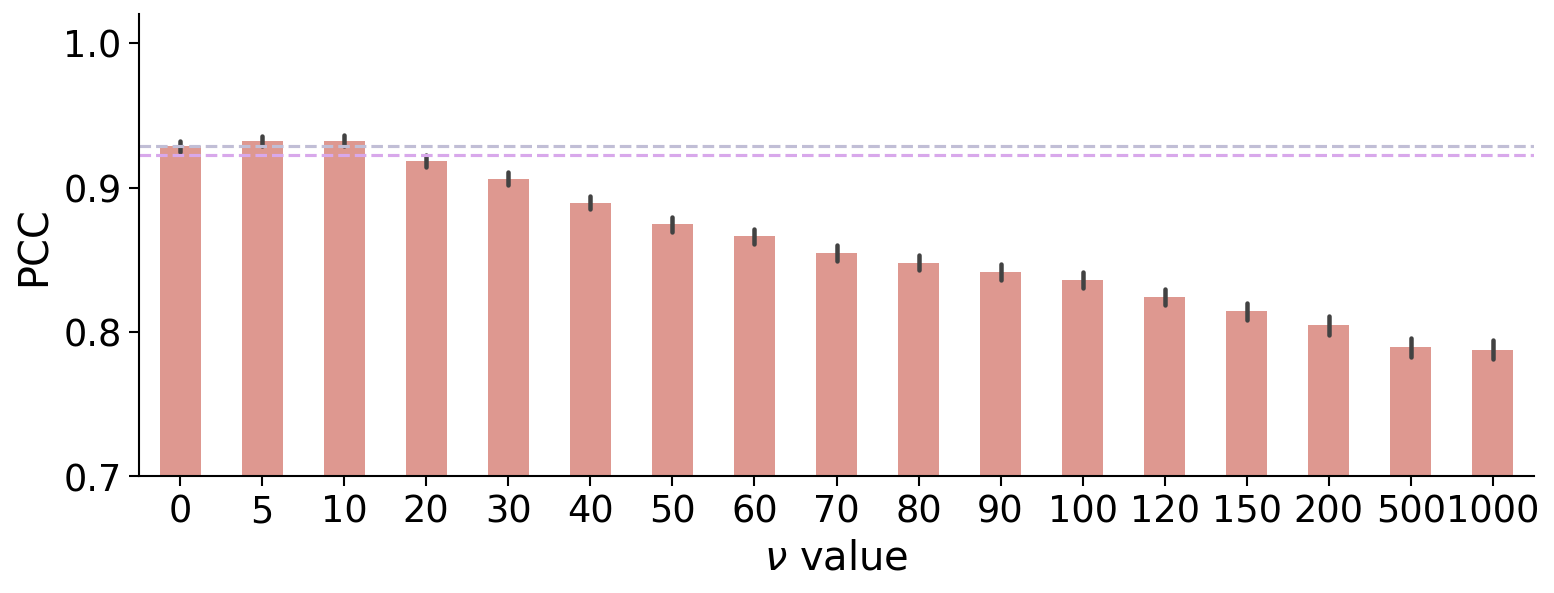

In [32]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
# plt.style.use('seaborn-whitegrid')
plt.style.use('default')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (12, 4), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="value",hue='method',data=vis_decon_df[(vis_decon_df.metric == 'pcc')], palette=['#C1BED6', '#D8A8EB', '#EB8E83'], ax = ax)
    sns.barplot(x="nu", y="value",data=vis_decon_df[(vis_decon_df.metric == 'pcc') & (vis_decon_df['method'] == 'SpatialScope')], width = 0.5, palette=['#EB8E83'], ax = ax)
ax.set_ylim(0.7,1.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.legend(bbox_to_anchor=(1,0.6))
# ax.legend_.remove()
#ax.set_yticks([0.84, 0.86, 0.88])
#ax.set_xticklabels(['130 UMIs','260 UMIs','520 UMIs'])
plt.axhline(y=vis_decon_df[(vis_decon_df['method'] == 'RCTD') & (vis_decon_df['metric'] == 'pcc')].value.mean(), color='#C1BED6', linestyle='--', linewidth = 1.5)
plt.axhline(y=vis_decon_df[(vis_decon_df['method'] == 'StarDist+RCTD') & (vis_decon_df['metric'] == 'pcc')].value.mean(), color='#D8A8EB', linestyle='--', linewidth = 1.5)
plt.ylabel('PCC')
plt.xlabel(r'$\nu$ value')
plt.show()

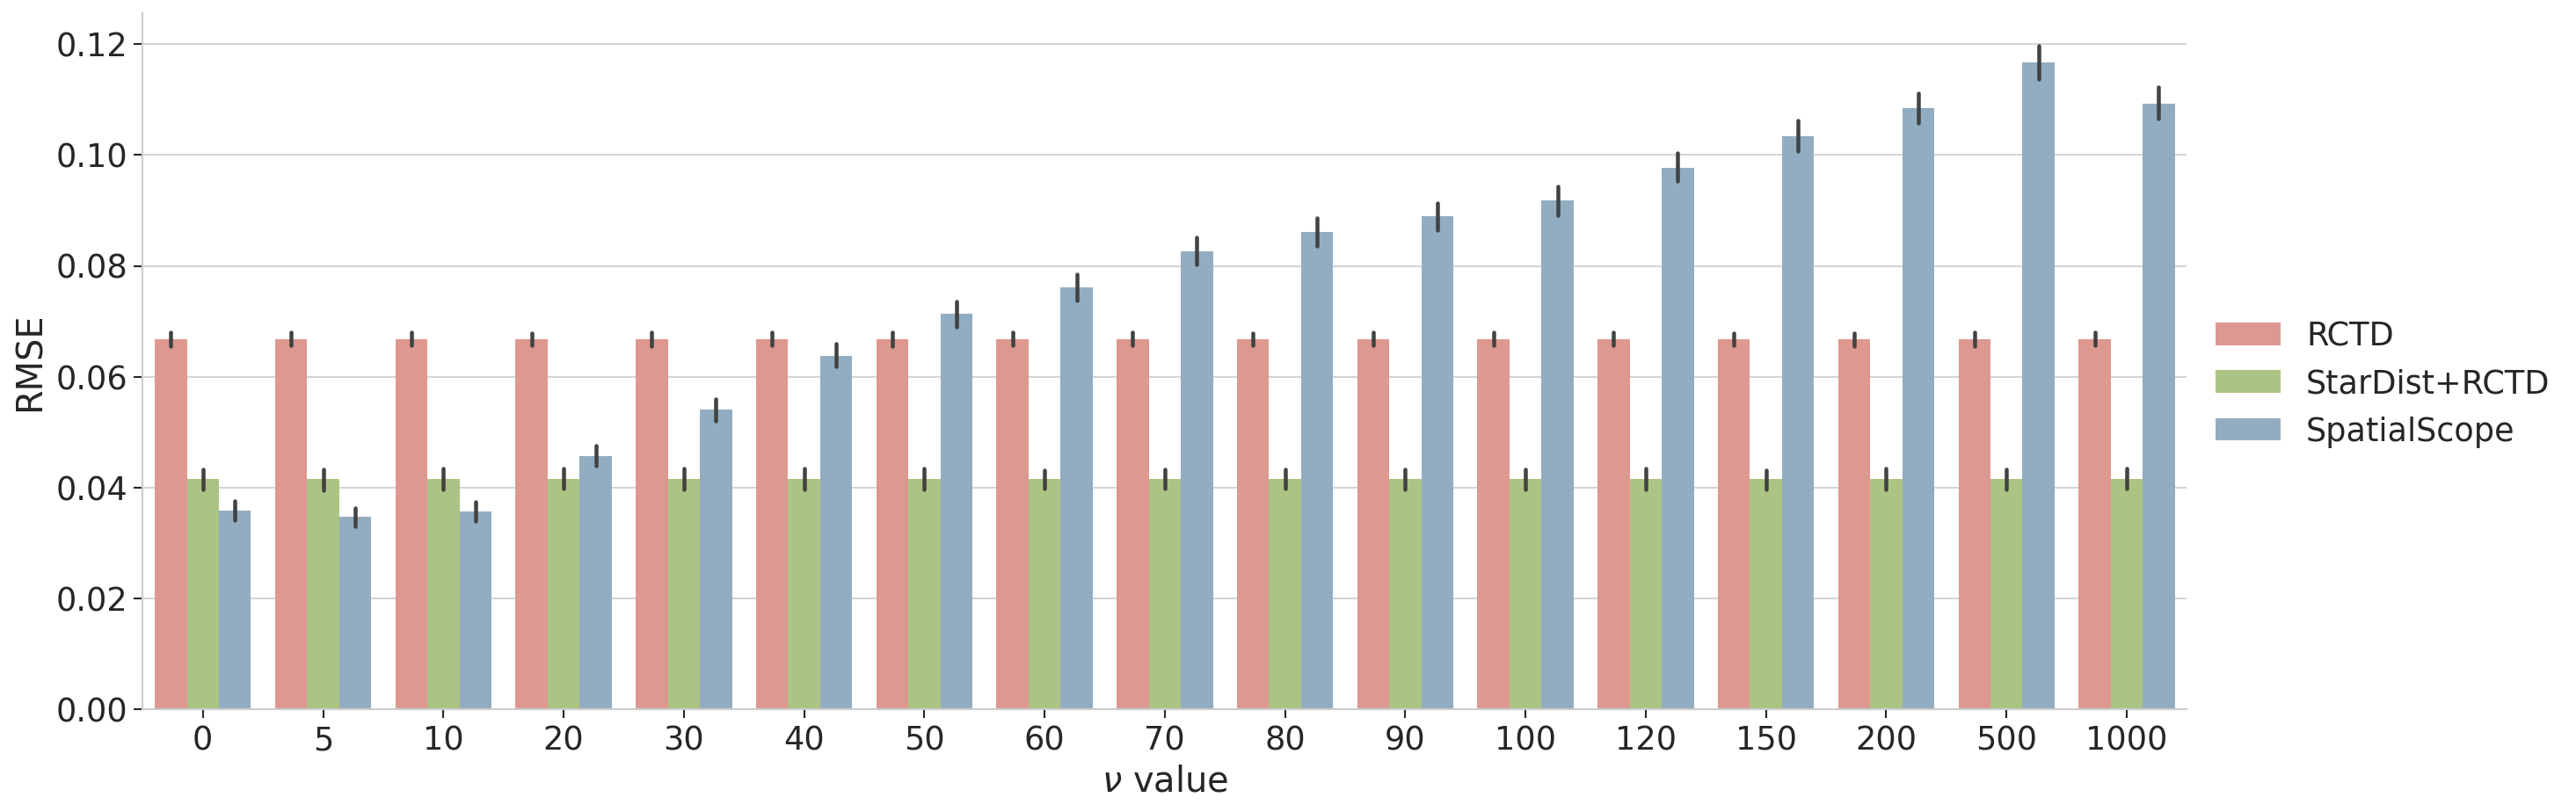

In [41]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (20, 7), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
    sns.barplot(x="nu", y="value",hue='method',data=vis_decon_df[vis_decon_df.metric == 'rmse'], palette=['#EA8E83', '#AFCF78', '#8AAEC9'], ax = ax)
# ax.set_ylim(0.4,0.95)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(bbox_to_anchor=(1,0.6))
#ax.set_yticks([0.84, 0.86, 0.88])
#ax.set_xticklabels(['130 UMIs','260 UMIs','520 UMIs'])
plt.ylabel('RMSE')
plt.xlabel(r'$\nu$ value')
plt.show()

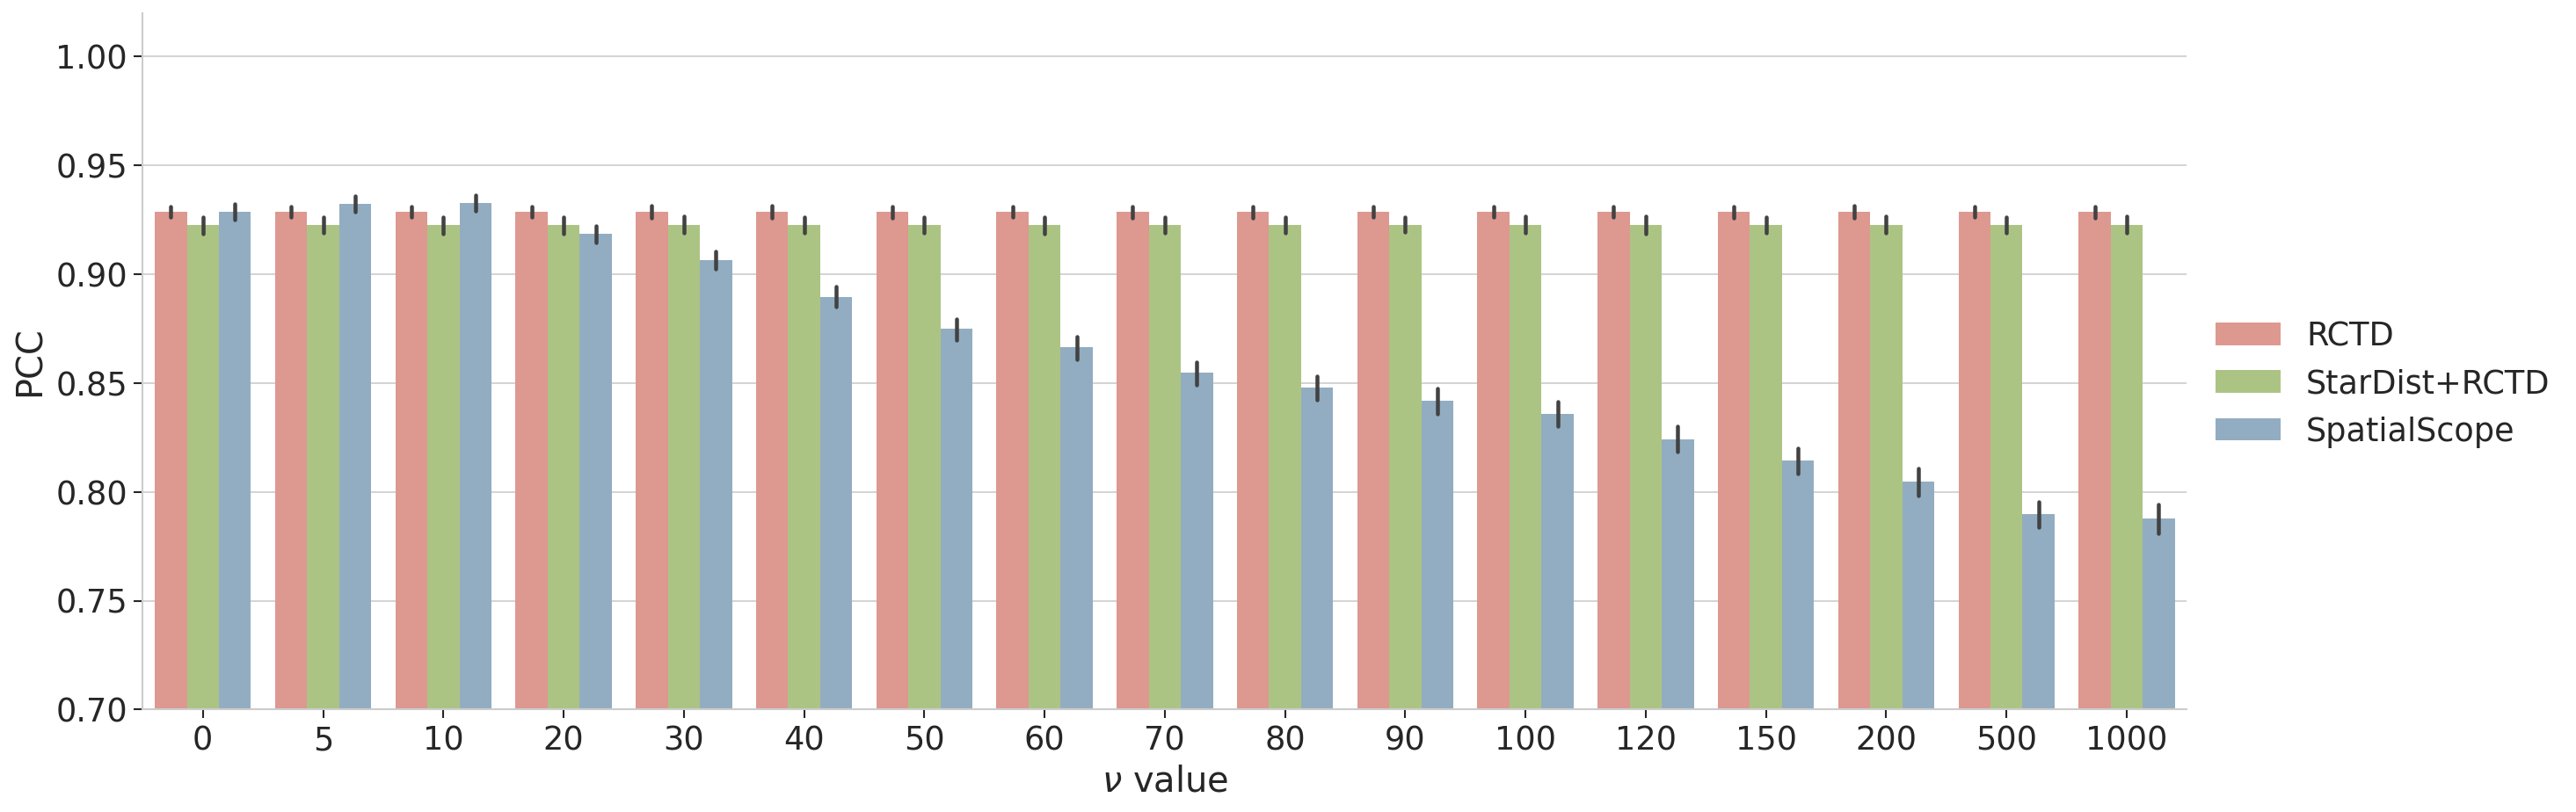

In [44]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (20, 7), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
    sns.barplot(x="nu", y="value",hue='method',data=vis_decon_df[vis_decon_df.metric == 'pcc'], palette=['#EA8E83', '#AFCF78', '#8AAEC9'], ax = ax)
ax.set_ylim(0.7,1.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(bbox_to_anchor=(1,0.6))
#ax.set_yticks([0.84, 0.86, 0.88])
#ax.set_xticklabels(['130 UMIs','260 UMIs','520 UMIs'])
plt.ylabel('PCC')
plt.xlabel(r'$\nu$ value')
plt.show()

## example results

In [45]:
nu = 10
cell_locations = pd.read_csv(os.path.join(DataDir, 'rep' + str(0), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

SR_results = sc.read(os.path.join(DataDir, 'rep' + str(0), 'SDRCTD_results/single_cell_type_label_bySDRCTD.h5ad'))
SR_cell_type_label = SR_results.uns['cell_locations'].copy()

In [46]:
sp_adata = sc.read(os.path.join(DataDir, 'spatial.h5ad'))
sp_adata.obs[np.array(['x', 'y'])].to_csv(DataDir + '/gt_loc.txt')
gd_results.to_csv(DataDir + '/gt_res.txt')

## ground truth

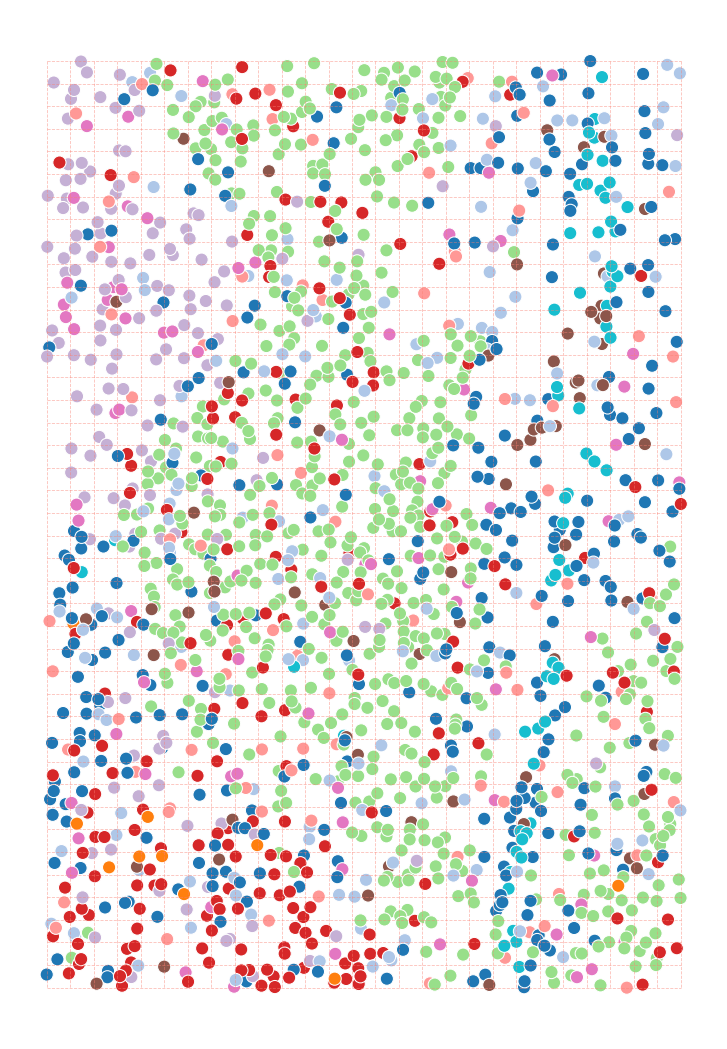

In [49]:
with mpl.rc_context({'figure.figsize': (6, 9), 'figure.dpi': 150}):
    ax = sns.scatterplot(data=cell_locations, x="x", y="y", hue=sp_cell_class_column, s = 40, palette = color_dict, legend = False)
    ax.invert_yaxis()
    for i in range(x_seg.shape[0]):
        ax.plot([x_seg[i] for _ in y_seg],y_seg,linestyle='dashed', c = 'salmon', lw = .4, alpha = 0.5)
    for i in range(y_seg.shape[0]):    
        ax.plot(x_seg,[y_seg[i] for _ in x_seg],linestyle='dashed', c = 'salmon', lw = .4, alpha = 0.5)
#         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.axis('off')

## SpatialScope

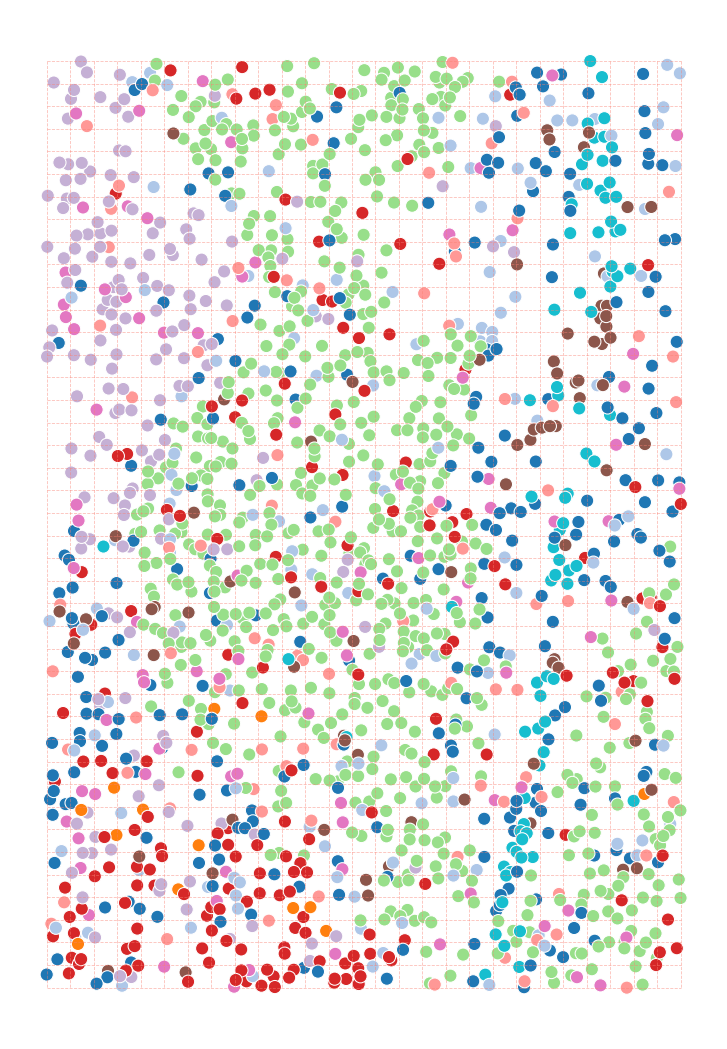

In [48]:
with mpl.rc_context({'figure.figsize': (6, 9), 'figure.dpi': 150}):
    ax = sns.scatterplot(data=cell_locations, x="x", y="y", hue='discrete_label_ct', s = 40, palette = color_dict, legend = False)
    ax.invert_yaxis()
    for i in range(x_seg.shape[0]):
        ax.plot([x_seg[i] for _ in y_seg],y_seg,linestyle='dashed', c = 'salmon', lw = .4, alpha = 0.5)
    for i in range(y_seg.shape[0]):    
        ax.plot(x_seg,[y_seg[i] for _ in x_seg],linestyle='dashed', c = 'salmon', lw = .4, alpha = 0.5)
#         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.axis('off')

### StarDist + RCTD 

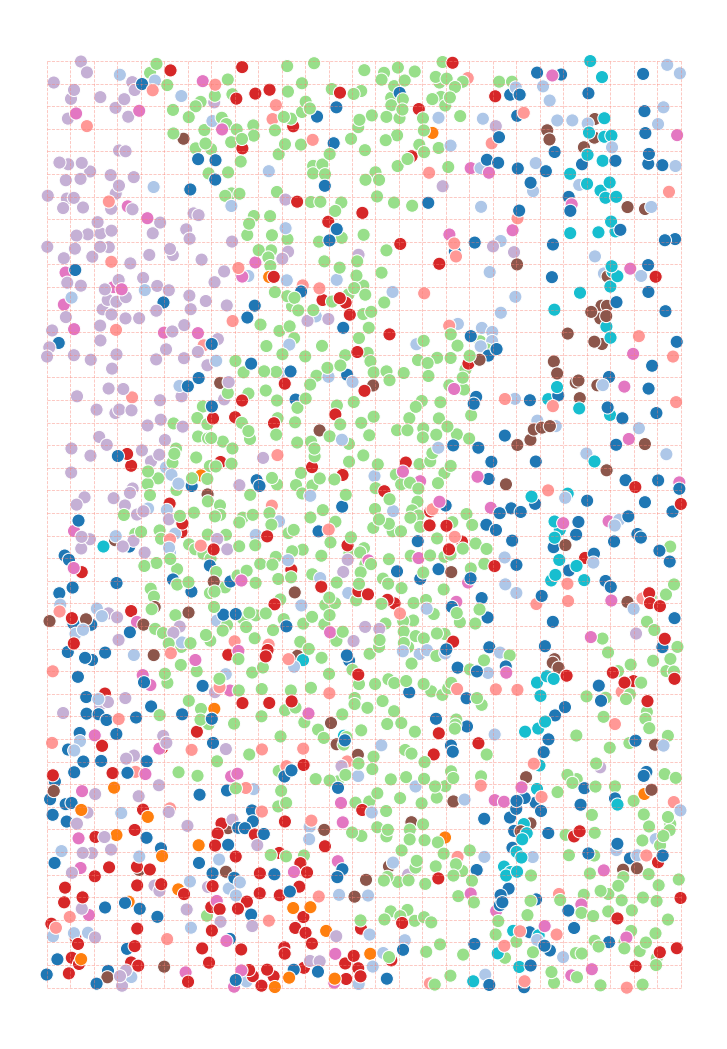

In [50]:
with mpl.rc_context({'figure.figsize': (6, 9), 'figure.dpi': 150}):
    ax = sns.scatterplot(data=SR_cell_type_label, x="x", y="y", hue='SDRCTD_cell_type', s = 40, palette = color_dict, legend = False)
    ax.invert_yaxis()
    for i in range(x_seg.shape[0]):
        ax.plot([x_seg[i] for _ in y_seg],y_seg,linestyle='dashed', c = 'salmon', lw = .4, alpha = 0.5)
    for i in range(y_seg.shape[0]):    
        ax.plot(x_seg,[y_seg[i] for _ in x_seg],linestyle='dashed', c = 'salmon', lw = .4, alpha = 0.5)
#         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.axis('off')